# (Core) Project 1: Global Explanations

## Imports

In [6]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

In [2]:
## Importing Custom Functions
import sys,os
sys.path.append(os.path.abspath("../"))
%load_ext autoreload
%autoreload 2
from CODE import data_enrichment as de


### Functionized Code From Part1m 1

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [8]:
## Load the joblib file stored in the models folder
fname = "./Models/wk1-lect01-codealong.joblib"
loaded = joblib.load(fname)

# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [9]:
## Saving the loaded objects as separate varaibles
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

### Re-Creating X_train_df & X_test_df

In [11]:
## Get feature names from already-fit preprocessor
feature_names = preprocessor.get_feature_names_out()


## Use the preprocessor to transform X_train and X_test
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8269,-1.320469,-0.043295,-1.268171,0.026015
7604,-1.575911,0.248066,-0.459996,1.338206
2762,-0.159793,-0.726880,0.182616,0.741756
6464,-1.620643,0.511794,-0.192206,0.741756
4707,1.264565,-0.002094,1.735461,0.741756


### Evaluating Our LinearRegression

In [13]:
## Use our evaluate_regression function to evalaute the linear regression
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.34,"1,012.90","1,370.71"
Test,0.34,"1,048.37","1,422.88"


In [15]:
## Setting float format for readability
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

In [16]:
## Get the coefficients from the lin reg
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                    -1.56
Item_Visibility              -225.83
Item_MRP                      959.95
Outlet_Establishment_Year     -93.65
intercept                   2,153.64
dtype: float64

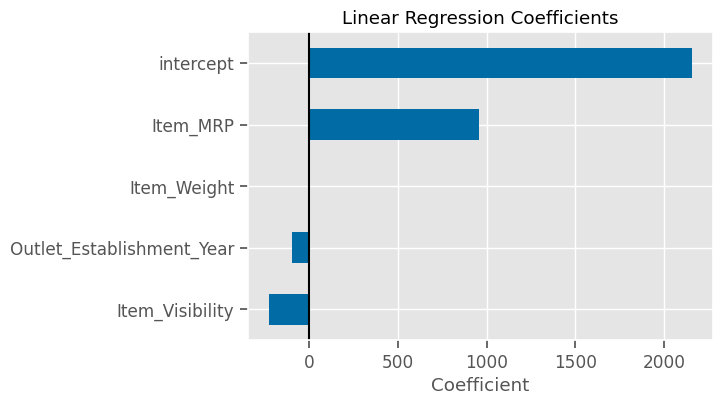

In [21]:
## plot the coefficients
plot_coefficients(coeffs);

### Evaluating Our Random Forest

Split,R^2,MAE,RMSE
Train,0.91,347.61,498.31
Test,0.36,982.02,"1,403.88"


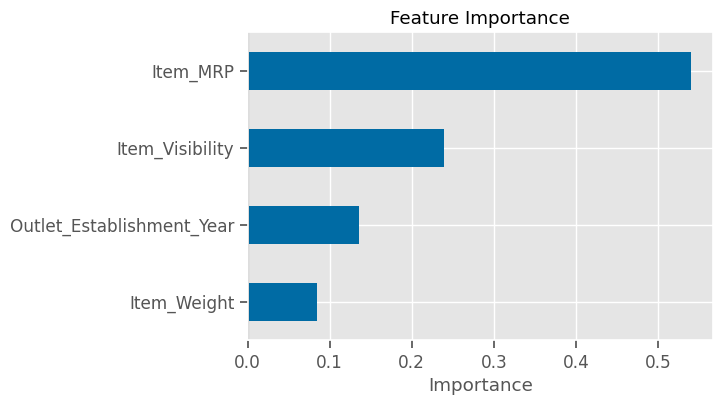

In [20]:
## evaluate the random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

## extract the plot the feature importances
importances = get_importances(rf_reg)
plot_importances(importances);

## Permutation Importance

In [23]:
from sklearn.inspection import permutation_importance

### RandomForest Permutation Importance

In [25]:
## run performatation_importance on the rf  using the test data and random_state=SEED
result = permutation_importance(rf_reg, X_test_df, y_test,scoring='r2',
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [26]:
## save the average importances as a Series
perm_importances = pd.Series(result['importances_mean'], index=rf_reg.feature_names_in_)
perm_importances

Item_Weight                 -0.02
Item_Visibility              0.05
Item_MRP                     0.67
Outlet_Establishment_Year    0.20
dtype: float64

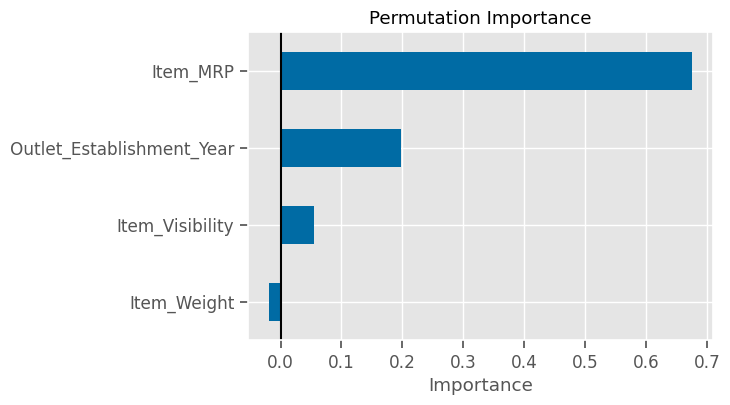

<AxesSubplot: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [27]:
# Use our plot_importances function, but change title to "Permutation Importance"
plot_importances(perm_importances,title='Permutation Importance')

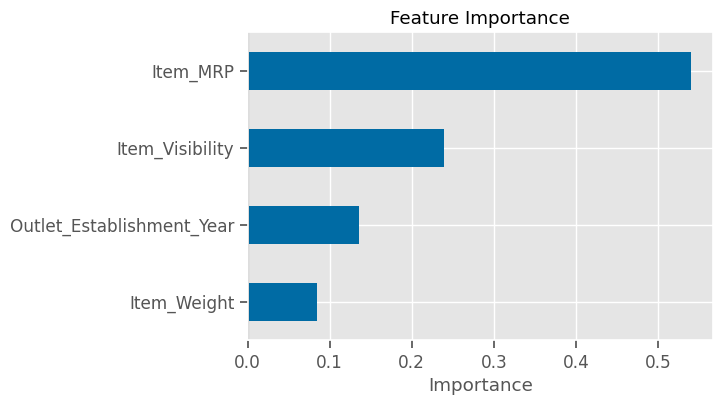

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [28]:
# Compare to the random forst feature importance
plot_importances(importances)

## Global Model Explanations
###  Applying Shap

In [29]:
# Import and init shap
import shap
shap.initjs()

In [30]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train_df,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
4469,-1.20,0.16,-1.02,-1.29
4438,-1.82,-0.61,0.39,0.74
366,-1.13,0.23,1.88,0.74
2219,-0.96,-0.31,-0.18,0.15
6080,-1.47,2.12,-0.92,0.03


In [31]:
# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
shap_values = explainer(X_shap,y_shap)

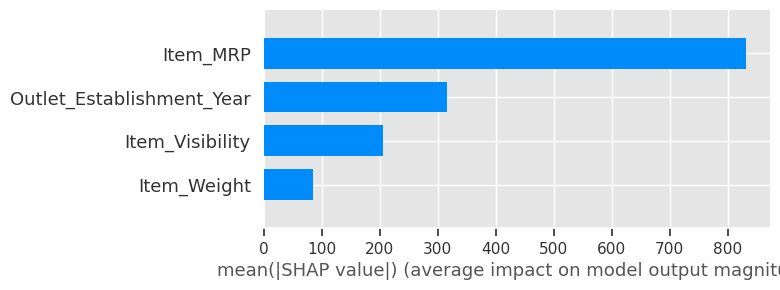

In [32]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


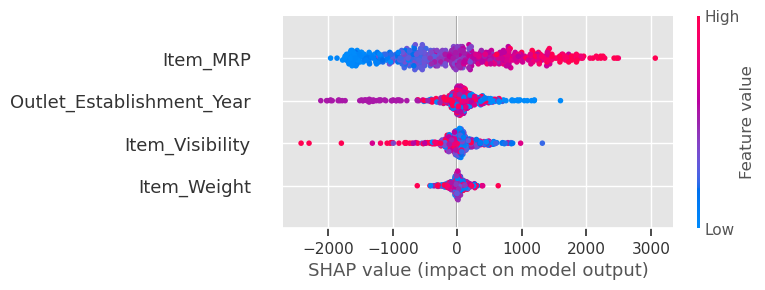

In [33]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)

In [34]:
## Create an explainer for the lin_reg
explainer_linreg = shap.Explainer(lin_reg, X_shap)

## get shap values for linreg
shap_values_linreg = explainer_linreg(X_shap)
shap_values_linreg.shape

(500, 4)

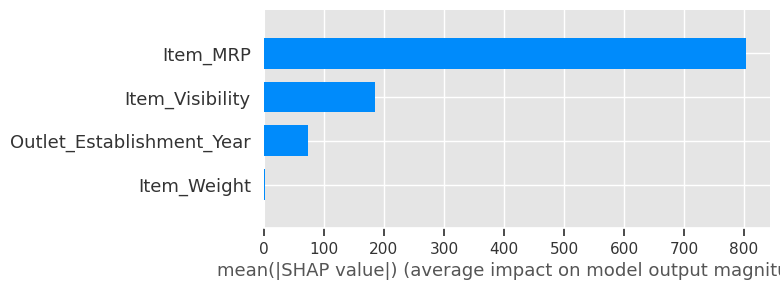

In [35]:
# create a summary plot (bar version)
shap.summary_plot(shap_values_linreg, features = X_shap, plot_type='bar')

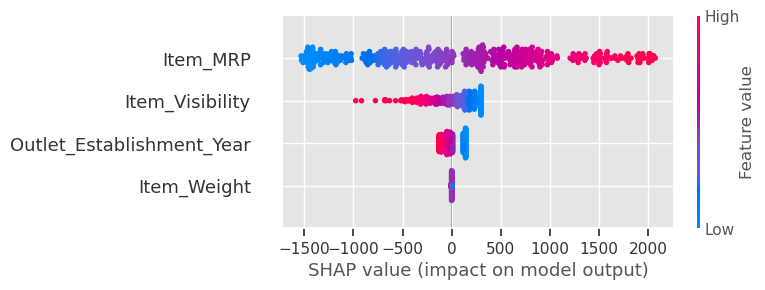

In [36]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values_linreg, features = X_shap)

## Shape Summary
- MRP
> The higher the MRP increase the likehood of predicting item sales

- Visibility:
> The smaller the visibilty, the model likehood decrease in sales prediction 


## Individual Explanations
### Local Explanations

In [39]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
0,-1.20,0.16,-1.02,-1.29
1,-1.82,-0.61,0.39,0.74
2,-1.13,0.23,1.88,0.74
3,-0.96,-0.31,-0.18,0.15
4,-1.47,2.12,-0.92,0.03


### Finding a Meaningful  Example to Explain

>- Let's find the example with the highest Item_MRP.

In [40]:
# what is the max/range of infant deaths
X_shap_local['Item_MRP'].describe()

count   500.00
mean     -0.04
std       1.00
min      -1.73
25%      -0.80
50%       0.01
75%       0.64
max       2.02
Name: Item_MRP, dtype: float64

In [42]:
# saving the index of the highest MRP Item
idx_high_MRP = X_shap_local['Item_MRP'].idxmax()
idx_high_MRP

431

In [43]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_MRP]

Item_Weight                 -0.67
Item_Visibility             -0.78
Item_MRP                     2.02
Outlet_Establishment_Year    1.34
Name: 431, dtype: float64

In [44]:
## what was the actual MRP Item sales?
y_shap_local.iloc[idx_high_MRP]

3171.8712

## Individual Shap Force Plots
### Force Plot - Linear Reg explanation

In [56]:
## plotting example force plot for highest Item MRP (from linreg)
shap.force_plot(explainer_linreg.expected_value, 
                shap_values=shap_values_linreg[idx_high_MRP].values,
               features=X_shap_local.iloc[idx_high_MRP])

### Force Plot - RandomForest explanation

In [52]:
## plotting example force plot for highest Item MRP (from rf)
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_high_MRP].values,
               features=X_shap_local.iloc[idx_high_MRP])

## LIME

In [53]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [55]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_MRP],
                                      rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


## LIME Summary

> For the item ```431th```, The MRP has a stronge correlation to predict the target vaue: Outlet sales.